# Deep Learning applied to Nodule Segmentation in Lung CT-scans

# Load Dicom Data

In [1]:
!pwd

/home/mas/x110/DLToolboxImg


In [2]:
#!touch requirements.txt
#!pip freeze -r requirements.txt

In [3]:
%reload_ext autoreload
%autoreload 2
#%matplotlib inline

In [4]:
import pylidc as pl #pip install -Iv scikit-image==0.13
from random import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import scipy

In [5]:
files = !ls drive/LIDC-dataset/data/LIDC-IDRI
files = ['LIDC-IDRI-0001',
 'LIDC-IDRI-0002',
 'LIDC-IDRI-0003',
 'LIDC-IDRI-0004',
 'LIDC-IDRI-0005',
 'LIDC-IDRI-0006',
 'LIDC-IDRI-0007',
 'LIDC-IDRI-0008',
 'LIDC-IDRI-0009',
 'LIDC-IDRI-0010',
 'LIDC-IDRI-0011',
 'LIDC-IDRI-0012']

In [6]:
qu = pl.query(pl.Scan)

In [7]:
scans=qu.all() #all scans in the original LIDC dataset
scans[0:5]

[Scan(id=1,patient_id=LIDC-IDRI-0078),
 Scan(id=2,patient_id=LIDC-IDRI-0069),
 Scan(id=3,patient_id=LIDC-IDRI-0079),
 Scan(id=4,patient_id=LIDC-IDRI-0101),
 Scan(id=5,patient_id=LIDC-IDRI-0110)]

In [8]:
ind = [i for i,s in enumerate(scans) if s.patient_id =="LIDC-IDRI-0001"]
ind

[11]

In [9]:
ind = [i for i,s in enumerate(scans) if s.patient_id in files]
ind

[11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]

In [10]:
mini_scans=[scans[i] for i in ind];  mini_scans

[Scan(id=12,patient_id=LIDC-IDRI-0001),
 Scan(id=13,patient_id=LIDC-IDRI-0002),
 Scan(id=14,patient_id=LIDC-IDRI-0003),
 Scan(id=15,patient_id=LIDC-IDRI-0004),
 Scan(id=16,patient_id=LIDC-IDRI-0005),
 Scan(id=17,patient_id=LIDC-IDRI-0006),
 Scan(id=18,patient_id=LIDC-IDRI-0007),
 Scan(id=19,patient_id=LIDC-IDRI-0008),
 Scan(id=20,patient_id=LIDC-IDRI-0009),
 Scan(id=21,patient_id=LIDC-IDRI-0010),
 Scan(id=22,patient_id=LIDC-IDRI-0011),
 Scan(id=23,patient_id=LIDC-IDRI-0012)]

In [11]:
scan=mini_scans[0]
scan.annotations

[Annotation(id=84,scan_id=12),
 Annotation(id=85,scan_id=12),
 Annotation(id=86,scan_id=12),
 Annotation(id=87,scan_id=12)]

Loading dicom files ... This may take a moment.


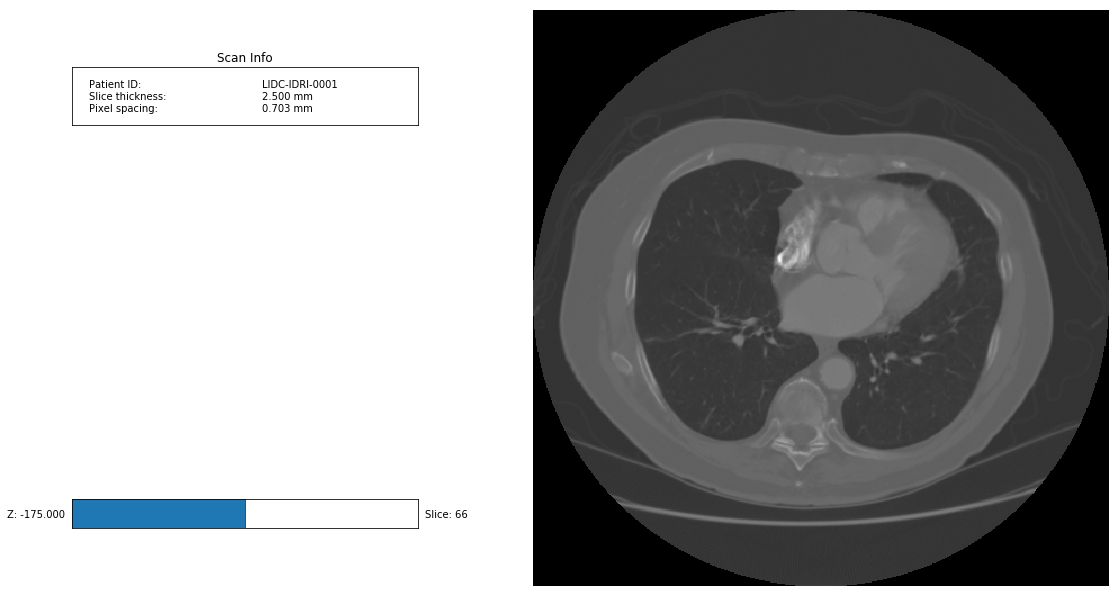

In [12]:
scan.visualize()

In [13]:
#check all scans are ok to read
scans_ok=[]
scans_error=[]

for q in mini_scans:
    try:
        q.get_path_to_dicom_files()
        scans_ok.append(q)
    except:
        scans_error.append(q)

print(len(scans_ok),len(scans_error),len(mini_scans))

12 0 12


# Split data to train, validate, test

In [14]:
import random
import numpy as np

In [15]:
#shuffle data, then split to train, valid, test
random.seed(313)
random.shuffle(scans_ok)
len(scans_ok)

12

In [16]:
L=len(scans_ok)
j=np.int(.6*L)
jj=np.int(.2*L)
j,jj

(7, 2)

In [17]:
scans_train=scans_ok[0:j]
scans_valid=scans_ok[j:j+jj]
scans_test=scans_ok[j+jj:]
print(len(scans_train),len(scans_valid),len(scans_test))

7 2 3


In [18]:
scans_train,scans_valid,scans_test

([Scan(id=15,patient_id=LIDC-IDRI-0004),
  Scan(id=16,patient_id=LIDC-IDRI-0005),
  Scan(id=17,patient_id=LIDC-IDRI-0006),
  Scan(id=22,patient_id=LIDC-IDRI-0011),
  Scan(id=20,patient_id=LIDC-IDRI-0009),
  Scan(id=23,patient_id=LIDC-IDRI-0012),
  Scan(id=13,patient_id=LIDC-IDRI-0002)],
 [Scan(id=12,patient_id=LIDC-IDRI-0001),
  Scan(id=19,patient_id=LIDC-IDRI-0008)],
 [Scan(id=18,patient_id=LIDC-IDRI-0007),
  Scan(id=14,patient_id=LIDC-IDRI-0003),
  Scan(id=21,patient_id=LIDC-IDRI-0010)])

# Filter annotation according to nodule diameter



In [19]:
scans0=scans_train
filename = "drive/df2_ann_filter_train.csv"

#consider only annonations of diameter < 30mm  and greater than 6mm 

if True:

    l=[q.annotations for q in scans0]
    anns = [item for sublist in l for item in sublist]

    columns=['ann_id','scan_id','nodule_diameter']

    df=[]
    for scan in scans0:
        for a in scan.annotations:
            row = [a.id,a.scan_id,a.diameter]
            df.append(row)

    df1=pd.DataFrame(df,columns=columns)
    #keep nodules between 6mm and 30 mm
    df2=df1[(df1.nodule_diameter<=30) & (df1.nodule_diameter>=6)]
    df2.reset_index(inplace=True,drop=True)
    df2.to_csv(filename)
    df_train=df2
else: 
    df_train=pd.read_csv(filename,index_col=0)
print(df_train.shape[0])
df_train.head()

63


,ann_id,scan_id,nodule_diameter
0,103,15,6.262191
1,105,15,7.025444
2,106,15,8.465747
3,107,16,6.264748
4,108,16,8.658309


In [20]:
#Repeat for validation set
scans0=scans_valid
filename = "drive/df2_ann_filter_valid.csv"
#consider only annonations of diameter < 30mm  and greater than 6mm 

if True:

    l=[q.annotations for q in scans0]
    anns = [item for sublist in l for item in sublist]

    columns=['ann_id','scan_id','nodule_diameter']

    df=[]
    for scan in scans0:
        for a in scan.annotations:
            row = [a.id,a.scan_id,a.diameter]
            df.append(row)

    df1=pd.DataFrame(df,columns=columns)
    #keep nodules between 6mm and 30 mm
    df2=df1[(df1.nodule_diameter<=30) & (df1.nodule_diameter>=6)]
    df2.reset_index(inplace=True,drop=True)
    df2.to_csv(filename)
    df_valid=df2
    #print(f"df1.shape[0],df2.shape[0]:{df1.shape[0]},{df2.shape[0]}")
else: 
    df_valid=pd.read_csv(filename,index_col=0)
print(df_valid.shape[0])
df_valid.head()

7


,ann_id,scan_id,nodule_diameter
0,129,19,8.156489
1,130,19,6.987712
2,131,19,11.718750
3,132,19,8.907621
4,133,19,8.156489


In [21]:
#Repeat for validation set
scans0=scans_test
filename = "drive/df2_ann_filter_test.csv"
#consider only annonations of diameter < 30mm  and greater than 6mm 

if True:

    l=[q.annotations for q in scans0]
    anns = [item for sublist in l for item in sublist]

    columns=['ann_id','scan_id','nodule_diameter']

    df=[]
    for scan in scans0:
        for a in scan.annotations:
            row = [a.id,a.scan_id,a.diameter]
            df.append(row)

    df1=pd.DataFrame(df,columns=columns)
    #keep nodules between 6mm and 30 mm
    df2=df1[(df1.nodule_diameter<=30) & (df1.nodule_diameter>=6)]
    df2.reset_index(inplace=True,drop=True)
    df2.to_csv(filename)
    df_test=df2
    #print(f"df1.shape[0],df2.shape[0]:{df1.shape[0]},{df2.shape[0]}")
else: 
    df_test=pd.read_csv(filename,index_col=0)
print(df_test.shape[0])
df_test.head()

16


,ann_id,scan_id,nodule_diameter
0,125,18,20.684691
1,91,14,13.353712
2,92,14,14.674187
3,94,14,14.326133
4,95,14,11.943923


# Plot distribution of nodule diameter

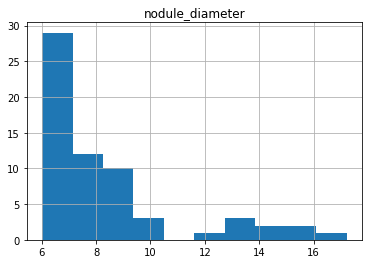

In [22]:
df_train.hist(column='nodule_diameter')
plt.show()

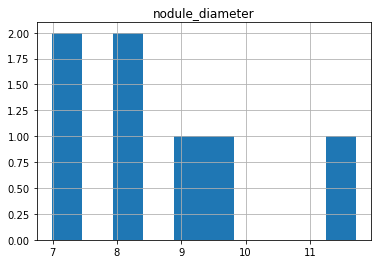

In [23]:
#look at  the distribution of nodules after filtering
df_valid.hist(column='nodule_diameter')
plt.show()

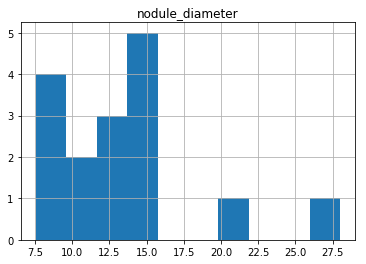

In [24]:
#look at  the distribution of nodules after filtering
df_test.hist(column='nodule_diameter')
plt.show()

The distribution of the nodule diameter is higly unbalanced. The number of small nodules is greater than the number of large nodules. Hence,  if uniform sampling is used, the network will be biased towards small nodules.

In [25]:
root_dir="drive/"
interm_dir=root_dir+"interm5/"#save the scan ids that will be considered
if True:
    scan_id_train=list(set(df_train["scan_id"]))
    scan_id_valid=list(set(df_valid["scan_id"]))
    scan_id_test=list(set(df_test["scan_id"]))
    filename=interm_dir+"scan_id_split"
    with open(filename, 'wb') as f:
        pickle.dump([scan_id_train,scan_id_valid,scan_id_test], f)
else:
    filename=interm_dir+"scan_id_split"
    with open(filename, 'rb') as f:
        scan_id_train,scan_id_valid,scan_id_test=pickle.load(f)

# Preprocessing: Converting the pixel values to Hounsfield Units (HU)

For the subsequence operations, it is useful to define a class which i named ''ctscan'

In [26]:
class ctscan():
  def __init__(self,scan_id):
    self.qu = pl.query(pl.Scan) #load data

    self.scan_id = scan_id

    self.scans = self.qu.all() 

    self.scan=self.scans[self.scan_id-1]

    self.slices= self.scan.load_all_dicom_images() #all raw slices of ctscan with metadata

    self.flag=0

    if len(self.slices)>1:
      for s in self.slices:
        try:
          s.pixel_array
        except:
          self.flag=-1
    
    if (self.flag==0 and len(self.slices)>1):
      self.image= np.stack([s.pixel_array for s in self.slices])
      self.image_HU=self.get_pixels_hu() #all slices of ctscan in Housenfield unit
            
  def get_pixels_hu(self):
    image = self.image.astype(np.float32)
    image[image<-1000]=0
    for slice_number in range(len(self.slices)):
      intercept = self.slices[slice_number].RescaleIntercept
      slope = self.slices[slice_number].RescaleSlope
      image[slice_number] = slope * image[slice_number]
      image[slice_number] += intercept
    return np.array(image, dtype=np.int16) #zxy

In [27]:
scan_id = scan_id_train[5]; scan_id

23

In [28]:
scan_1 = ctscan(scan_id)

Loading dicom files ... This may take a moment.


In [29]:
im = scan_1.image_HU

In [30]:
im.shape

(128, 512, 512)

<Figure size 432x288 with 0 Axes>

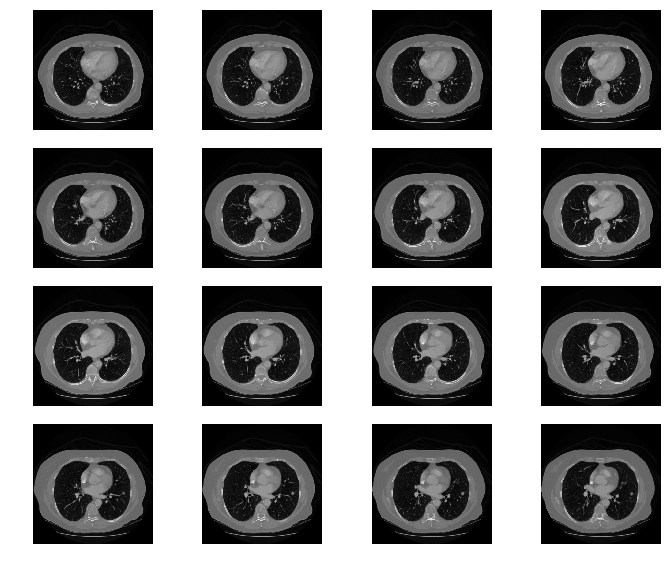

In [31]:
#plot some slices
plt.figure()
start=50
f, plots = plt.subplots(4, 4, sharex='col', sharey='row', figsize=(10, 8))
for i in range(16):
    plots[i // 4, i % 4].axis('off')
    plots[i // 4, i % 4].imshow(im[start+i], 'gray',interpolation='none')
plt.tight_layout()
plt.show()

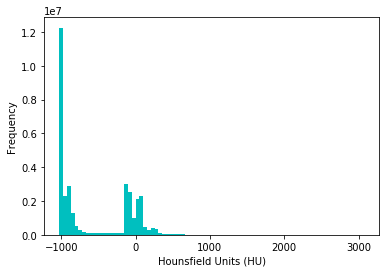

In [32]:
plt.hist(im.flatten(), bins=80, color='c')
plt.xlabel("Hounsfield Units (HU)")
plt.ylabel("Frequency")
plt.show()

# Preprocessing: Resampling the scans to have the same resolution

We continue to develop the ctscan to include more methods

In [33]:
class ctscan():
  def __init__(self,scan_id):
    self.qu = pl.query(pl.Scan) #load data

    self.scan_id = scan_id

    self.scans = self.qu.all() 

    self.scan=self.scans[self.scan_id-1]

    self.slices= self.scan.load_all_dicom_images() #all raw slices of ctscan with metadata

    self.flag=0
    
    

    if len(self.slices)>1:
      for s in self.slices:
        try:
          s.pixel_array
        except:
          self.flag=-1
    
    if (self.flag==0 and len(self.slices)>1):
      self.image= np.stack([s.pixel_array for s in self.slices])
      self.image_HU=self.get_pixels_hu() #all slices of ctscan in Housenfield unit
      
      self.slice_thickness=self.slices[1].ImagePositionPatient[2]-self.slices[0].ImagePositionPatient[2]
      self.original_spacing = [self.scan.pixel_spacing,self.scan.pixel_spacing,
                               self.slice_thickness]    
      self.desired_spacing = np.array([1,1,1])

      self.image_resampled,self.new_spacing=self.resample()

  def get_pixels_hu(self):
    image = self.image.astype(np.float32)
    image[image<-1000]=0
    for slice_number in range(len(self.slices)):
      intercept = self.slices[slice_number].RescaleIntercept
      slope = self.slices[slice_number].RescaleSlope
      image[slice_number] = slope * image[slice_number]
      image[slice_number] += intercept
    return np.array(image, dtype=np.int16) #zxy
  
  def resample(self):
        
    image=self.image_HU.copy() #zxy

    image=image.swapaxes(0,2) #yxz
    image=image.swapaxes(0,1) #xyz

    resize_factor = self.original_spacing/self.desired_spacing

    new_real_shape = image.shape * resize_factor

    new_shape = np.round(new_real_shape)

    real_resize_factor = new_shape/image.shape

    new_spacing = self.original_spacing/real_resize_factor

    image = scipy.ndimage.interpolation.zoom(image, real_resize_factor, mode='nearest')

    image=image.swapaxes(0,2) #zyx
    image=image.swapaxes(1,2) #zxy
    
    return image, new_spacing
  

In [34]:
scan_id = scan_id_train[5]; scan_id
scan_1 = ctscan(scan_id)

Loading dicom files ... This may take a moment.


In [35]:
im=scan_1.image_resampled
im.shape

(320, 380, 380)

<Figure size 432x288 with 0 Axes>

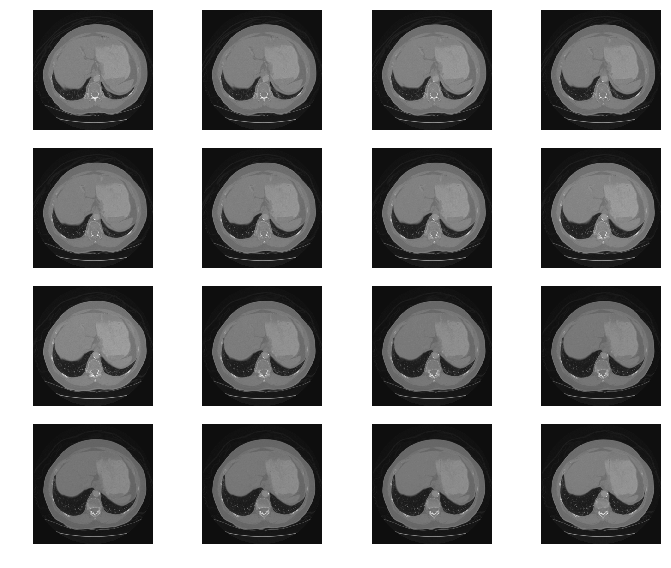

In [36]:
im=scan_1.image_resampled
#plot some slices
plt.figure()
start=50
f, plots = plt.subplots(4, 4, sharex='col', sharey='row', figsize=(10, 8))
for i in range(16):
    plots[i // 4, i % 4].axis('off')
    plots[i // 4, i % 4].imshow(im[start+i], 'gray',interpolation='none')
plt.tight_layout()
plt.show()

Let us look at the distribution of the original resolution. Also, let us look at the original scan size and the new scan size distributions.

In [37]:
filename = "drive/size_distribution_train.csv" 

if True:
  df = []
  columns=['original_spacing_x','original_spacing_y','original_spacing_z',
             'original_size_z','original_size_x','original_size_y',
            'new_size_z','new_size_x','new_size_y']
  for scan_id in scan_id_train:
    scan_1 = ctscan(scan_id)
    L=[scan_1.original_spacing,scan_1.image.shape,scan_1.image_resampled.shape]
    row = [v for sublist in L for v in sublist]

    df.append(row)

  df1=pd.DataFrame(df,columns=columns)
  df1.to_csv(filename)
else:
  df1 = pd.read_csv(filename,index_col=0)

Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.


In [38]:
df1.shape

(6, 9)

In [39]:
scan_id_train

[15, 16, 17, 20, 22, 23]

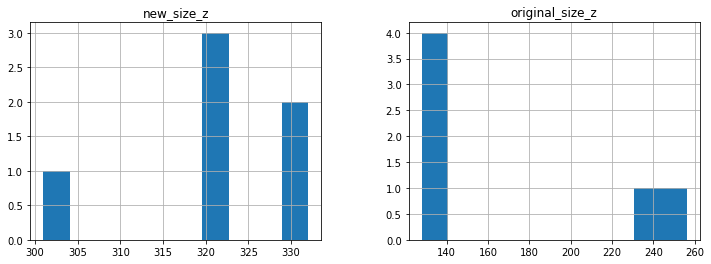

In [40]:
#look at  the distribution of nodules after filtering
columns=[
             'original_size_z',
            'new_size_z']
df1.hist(column=columns,figsize=(12,4))
plt.show()

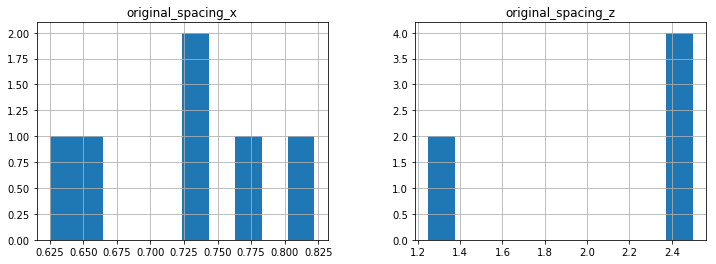

In [41]:
columns=['original_spacing_x','original_spacing_z']
df1.hist(column=columns,figsize=(12,4))
plt.show()

Most of the scans had 24 slices in the z direction. The original x spacing for this sample are less than 1mm. So, x was downsampled.

# Preprocessing: Normalization

Again, we modify the ctscan to include another method: Normalization. Now that we have the image in HU units, we know that values above 400 are not interesting as they refer to bones. 

In [42]:
class ctscan():
  def __init__(self,scan_id):
    self.qu = pl.query(pl.Scan) #load data

    self.scan_id = scan_id

    self.scans = self.qu.all() 

    self.scan=self.scans[self.scan_id-1]

    self.slices= self.scan.load_all_dicom_images() #all raw slices of ctscan with metadata

    self.flag=0
    
    

    if len(self.slices)>1:
      for s in self.slices:
        try:
          s.pixel_array
        except:
          self.flag=-1
    
    if (self.flag==0 and len(self.slices)>1):
      self.image= np.stack([s.pixel_array for s in self.slices])
      self.image_HU=self.get_pixels_hu() #all slices of ctscan in Housenfield unit
      
      self.slice_thickness=self.slices[1].ImagePositionPatient[2]-self.slices[0].ImagePositionPatient[2]
      self.original_spacing = [self.scan.pixel_spacing,self.scan.pixel_spacing,
                               self.slice_thickness]    
      self.desired_spacing = np.array([1,1,1])

      self.image_resampled,self.new_spacing=self.resample()
      self.image_normalized = self.normalize(self.image_resampled)

  def get_pixels_hu(self):
    image = self.image.astype(np.float32)
    image[image<-1000]=0
    for slice_number in range(len(self.slices)):
      intercept = self.slices[slice_number].RescaleIntercept
      slope = self.slices[slice_number].RescaleSlope
      image[slice_number] = slope * image[slice_number]
      image[slice_number] += intercept
    return np.array(image, dtype=np.int16) #zxy
  
  def resample(self):
        
    image=self.image_HU.copy() #zxy

    image=image.swapaxes(0,2) #yxz
    image=image.swapaxes(0,1) #xyz

    resize_factor = self.original_spacing/self.desired_spacing

    new_real_shape = image.shape * resize_factor

    new_shape = np.round(new_real_shape)

    real_resize_factor = new_shape/image.shape

    new_spacing = self.original_spacing/real_resize_factor

    image = scipy.ndimage.interpolation.zoom(image, real_resize_factor, mode='nearest')

    image=image.swapaxes(0,2) #zyx
    image=image.swapaxes(1,2) #zxy
    
    return image, new_spacing


  def normalize(self,image):
    MIN_BOUND = -1000.0
    MAX_BOUND = 400.0

    image = (image - MIN_BOUND) / (MAX_BOUND - MIN_BOUND)
    image[image>1] = 1.
    image[image<0] = 0.
    return image



Loading dicom files ... This may take a moment.


<Figure size 432x288 with 0 Axes>

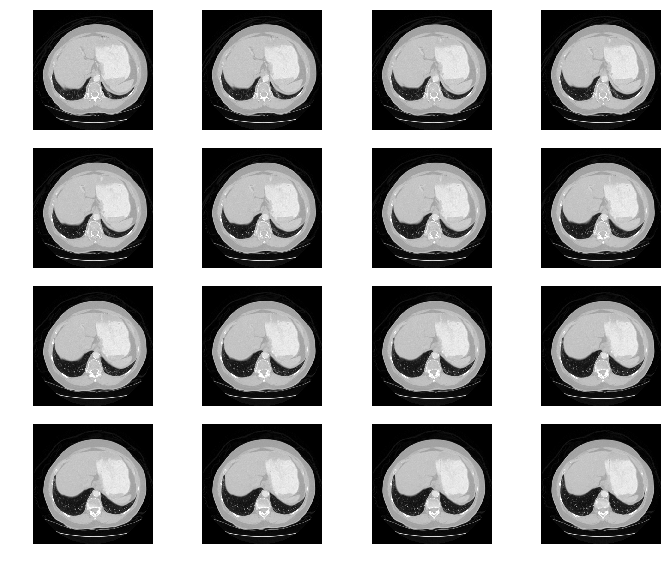

In [43]:
scan_id = scan_id_train[5]
scan_1 = ctscan(scan_id)
im=scan_1.image_normalized
#plot some slices
plt.figure()
start=50
f, plots = plt.subplots(4, 4, sharex='col', sharey='row', figsize=(10, 8))
for i in range(16):
    plots[i // 4, i % 4].axis('off')
    plots[i // 4, i % 4].imshow(im[start+i], 'gray',interpolation='none')
plt.tight_layout()
plt.show()

# Find the centroids of the nodules after resampling

We will modify the ctscan class to be able to find the centroid nodule in the new coordinate system after the scans has been resampled. 

In [44]:
 class ctscan():
  def __init__(self,scan_id):
    self.qu = pl.query(pl.Scan) #load data

    self.scan_id = scan_id

    self.scans = self.qu.all() 

    self.scan=self.scans[self.scan_id-1]

    self.slices= self.scan.load_all_dicom_images() #all raw slices of ctscan with metadata

    self.flag=0
    
    

    if len(self.slices)>1:
      for s in self.slices:
        try:
          s.pixel_array
        except:
          self.flag=-1
    
    if (self.flag==0 and len(self.slices)>1):
      self.image= np.stack([s.pixel_array for s in self.slices])
      self.image_HU=self.get_pixels_hu() #all slices of ctscan in Housenfield unit
      
      self.slice_thickness=self.slices[1].ImagePositionPatient[2]-self.slices[0].ImagePositionPatient[2]
      self.original_spacing = [self.scan.pixel_spacing,self.scan.pixel_spacing,
                               self.slice_thickness]    
      self.desired_spacing = np.array([1,1,1])

      self.image_resampled,self.new_spacing=self.resample()
      self.image_normalized = self.normalize(self.image_resampled)
      
      self.z0=float(self.slices[0].ImagePositionPatient[2]) #they are sorted by pylidc #get initial z position
      
      self.anns= self.scan.annotations

      self.centroids1=self.allcentroids1()

      self.centroids2=self.allcentroids2()


  def get_pixels_hu(self):
    image = self.image.astype(np.float32)
    image[image<-1000]=0
    for slice_number in range(len(self.slices)):
      intercept = self.slices[slice_number].RescaleIntercept
      slope = self.slices[slice_number].RescaleSlope
      image[slice_number] = slope * image[slice_number]
      image[slice_number] += intercept
    return np.array(image, dtype=np.int16) #zxy
  
  def resample(self):
        
    image=self.image_HU.copy() #zxy

    image=image.swapaxes(0,2) #yxz
    image=image.swapaxes(0,1) #xyz

    resize_factor = self.original_spacing/self.desired_spacing

    new_real_shape = image.shape * resize_factor

    new_shape = np.round(new_real_shape)

    real_resize_factor = new_shape/image.shape

    new_spacing = self.original_spacing/real_resize_factor

    image = scipy.ndimage.interpolation.zoom(image, real_resize_factor, mode='nearest')

    image=image.swapaxes(0,2) #zyx
    image=image.swapaxes(1,2) #zxy
    
    return image, new_spacing


  def normalize(self,image):
    MIN_BOUND = -1000.0
    MAX_BOUND = 400.0

    image = (image - MIN_BOUND) / (MAX_BOUND - MIN_BOUND)
    image[image>1] = 1.
    image[image<0] = 0.
    return image

  def centroid1(self,ann): #convert centroid from mm into pixel location#centroid in coordinates1
    #find centroid
    c =ann.centroid #row,col,z in original dimensions,m
    #find centroid with z in slice thickness
    c1=c.copy().astype(int)
    #c1[2]=np.int((c[2]-self.z0)/self.slice_thickness)
    return c1

  def centroid2(self,c1): #convert into spacing of 1,1,1
    c2=c1*self.original_spacing
    c2=c2.astype(np.int)
    return c2

  def allcentroids1(self): #all nodule centroids in the original coordinate system
    centroids=[]
    for ann in self.anns:
      c1=self.centroid1(ann)
      centroids.append(c1)
    return centroids
    
  def allcentroids2(self): #all nodule centroids in the resampled coordinate system
    centroids=[]
    for c1 in self.centroids1:
      c2=self.centroid2(c1)
      centroids.append(c2)
    return centroids
    

In [45]:
scan_id = scan_id_train[5];scan_id

23

In [46]:
scan_1 = ctscan(scan_id)

Loading dicom files ... This may take a moment.


In [47]:
scan_1.centroids1

[array([215, 389,  52]),
 array([295, 386,  63]),
 array([215, 364,  66]),
 array([199, 313,  71]),
 array([187, 360,  77]),
 array([188, 361,  78]),
 array([194, 335,  78]),
 array([169, 326,  79]),
 array([199, 313,  71]),
 array([216, 365,  66]),
 array([296, 386,  63]),
 array([216, 389,  52]),
 array([171, 157,  66]),
 array([205, 135,  44]),
 array([366, 164,  57]),
 array([188, 361,  78]),
 array([194, 334,  78]),
 array([170, 324,  79]),
 array([198, 313,  71]),
 array([215, 365,  66]),
 array([295, 386,  63]),
 array([215, 389,  52]),
 array([366, 164,  57]),
 array([205, 135,  44]),
 array([296, 386,  63]),
 array([215, 389,  52]),
 array([374, 162,  83]),
 array([366, 164,  57]),
 array([205, 134,  44]),
 array([215, 364,  66]),
 array([199, 313,  70]),
 array([188, 361,  77]),
 array([194, 334,  79]),
 array([170, 325,  78]),
 array([213, 371,  77]),
 array([170, 157,  65])]

In [48]:
scan_1.centroids2

[array([159, 288, 130]),
 array([218, 286, 157]),
 array([159, 270, 165]),
 array([147, 232, 177]),
 array([138, 267, 192]),
 array([139, 267, 195]),
 array([143, 248, 195]),
 array([125, 241, 197]),
 array([147, 232, 177]),
 array([160, 270, 165]),
 array([219, 286, 157]),
 array([160, 288, 130]),
 array([126, 116, 165]),
 array([152, 100, 110]),
 array([271, 121, 142]),
 array([139, 267, 195]),
 array([143, 247, 195]),
 array([126, 240, 197]),
 array([146, 232, 177]),
 array([159, 270, 165]),
 array([218, 286, 157]),
 array([159, 288, 130]),
 array([271, 121, 142]),
 array([152, 100, 110]),
 array([219, 286, 157]),
 array([159, 288, 130]),
 array([277, 120, 207]),
 array([271, 121, 142]),
 array([152,  99, 110]),
 array([159, 270, 165]),
 array([147, 232, 175]),
 array([139, 267, 192]),
 array([143, 247, 197]),
 array([126, 241, 195]),
 array([158, 275, 192]),
 array([126, 116, 162])]

# Find the bounding box around the nodule

In [12]:
class ctscan():
    def __init__(self,scan_id):
        self.qu = pl.query(pl.Scan) #load data

        self.scan_id = scan_id

        self.scans = self.qu.all() 

        self.scan=self.scans[self.scan_id-1]

        self.slices= self.scan.load_all_dicom_images() #all raw slices of ctscan with metadata

        self.flag=0
    
    

        if len(self.slices)>1:
            for s in self.slices:
                try:
                  s.pixel_array
                except:
                  self.flag=-1
    
        if (self.flag==0 and len(self.slices)>1):
            self.image= np.stack([s.pixel_array for s in self.slices])
            self.image_HU=self.get_pixels_hu() #all slices of ctscan in Housenfield unit

            self.slice_thickness=self.slices[1].ImagePositionPatient[2]-self.slices[0].ImagePositionPatient[2]
            self.original_spacing = [self.scan.pixel_spacing,self.scan.pixel_spacing,
                                   self.slice_thickness]    
            self.desired_spacing = np.array([1,1,1])

            self.image_resampled,self.new_spacing=self.resample()
            self.image_normalized = self.normalize(self.image_resampled)

            self.z0=float(self.slices[0].ImagePositionPatient[2]) #they are sorted by pylidc #get initial z position

            self.anns= self.scan.annotations

            self.centroids1=self.allcentroids1()

            self.centroids2=self.allcentroids2()

            self.zarrs = [self.get_ann_z(ann) for ann in self.anns] #for each annotations get the z axis that it spans

            self.c2vsz=self.find_all_centroids()
            
            self.Zbbox=self.find_all_bbox()

            #self.Z2=self.find_msk()


    def get_pixels_hu(self):
        image = self.image.astype(np.float32)
        image[image<-1000]=0
        for slice_number in range(len(self.slices)):
            intercept = self.slices[slice_number].RescaleIntercept
            slope = self.slices[slice_number].RescaleSlope
            image[slice_number] = slope * image[slice_number]
            image[slice_number] += intercept
        return np.array(image, dtype=np.int16) #zxy
  
    def resample(self):

        image=self.image_HU.copy() #zxy

        image=image.swapaxes(0,2) #yxz
        image=image.swapaxes(0,1) #xyz

        resize_factor = self.original_spacing/self.desired_spacing

        new_real_shape = image.shape * resize_factor

        new_shape = np.round(new_real_shape)

        real_resize_factor = new_shape/image.shape

        new_spacing = self.original_spacing/real_resize_factor

        image = scipy.ndimage.interpolation.zoom(image, real_resize_factor, mode='nearest')

        image=image.swapaxes(0,2) #zyx
        image=image.swapaxes(1,2) #zxy

        return image, new_spacing


    def normalize(self,image):
        MIN_BOUND = -1000.0
        MAX_BOUND = 400.0

        image = (image - MIN_BOUND) / (MAX_BOUND - MIN_BOUND)
        image[image>1] = 1.
        image[image<0] = 0.
        return image

    def centroid1(self,ann): #convert centroid from mm into pixel location#centroid in coordinates1
        #find centroid
        row,col,depth =ann.centroid #row,col,z in original dimensions,m
        c=np.array([col,row,depth])
        #find centroid with z in slice thickness
        c1=c.copy().astype(int)
        #c1[2]=np.int((c[2]-self.z0)/self.slice_thickness)
        return c1

    def centroid2(self,c1): #convert into spacing of 1,1,1
        c2=c1*self.original_spacing
        c2=c2.astype(np.int)
        return c2

    def allcentroids1(self): #all nodule centroids in the original coordinate system
        centroids=[]
        for ann in self.anns:
            c1=self.centroid1(ann)
            centroids.append(c1)
        return centroids
    
    def allcentroids2(self): #all nodule centroids in the resampled coordinate system
        centroids=[]
        for c1 in self.centroids1:
            c2=self.centroid2(c1)
            centroids.append(c2)
        return centroids
    
    def bbox1(self,ann): #convert bbox from mm into pixel location
        #A=ann.bbox()
        #A[2]=(A[2]*1.0-self.z0)/self.slice_thickness
        A=ann.bbox_matrix()
        A=np.array([A[1],A[0],A[2]])
        return A
    
    def bbox2(self,ann): #convert into spacing of 1,1,1
        A1=self.bbox1(ann)
        A2=A1.T*self.original_spacing
        A2=A2.T
        return A2
    def get_ann_z(self,ann): #find the z that a nodule spans
        zs=[]
        A2=self.bbox2(ann)
        zarr=np.arange(A2[2][0],A2[2][1]+1).astype(np.int)
        return zarr

    #find centroid at each z location of the given volume
    def find_all_centroids(self):
        slices_num = self.image_resampled.shape[0]
        #initialize dict
        keys=np.arange(slices_num)
        Zc=dict() #The dict contains a mask for each z location
        [Zc.setdefault(key, []) for key in keys] #contains a centroid for each z

        for i,c2 in enumerate(self.centroids2):
            for key in self.zarrs[i]:
                Zc[key].append(c2[0:2])
        return Zc
    #find bottem left corner and dimension of bbox at each z location of the given volume
    def find_all_bbox(self):
        slices_num = self.image_resampled.shape[0]
        
        keys=np.arange(slices_num)
        Zxy=dict() #The dict contains a mask for each z location
        [Zxy.setdefault(key, []) for key in keys] #contains a centroid for each z
        
        for i,(ann,c2) in enumerate(zip(self.anns,self.centroids2)):
            A2=self.bbox2(ann)
            d1=A2.T[1]-A2.T[0]#bbox dim
            xy1=[c2[0]-d1[0]/2,c2[1]-d1[1]/2]
            for key in self.zarrs[i]:
                Zxy[key].append(xy1[0:2]+list(d1[0:2]))
        return Zxy

In [17]:
scan_id = 23

In [18]:
scan_1 = ctscan(scan_id)

Loading dicom files ... This may take a moment.


In [19]:
ims = scan_1.image_resampled
ims.shape

(320, 380, 380)

In [20]:
import matplotlib.patches as patches
%matplotlib nbagg
import matplotlib.animation as animation
from IPython.display import HTML

<IPython.core.display.Javascript object>


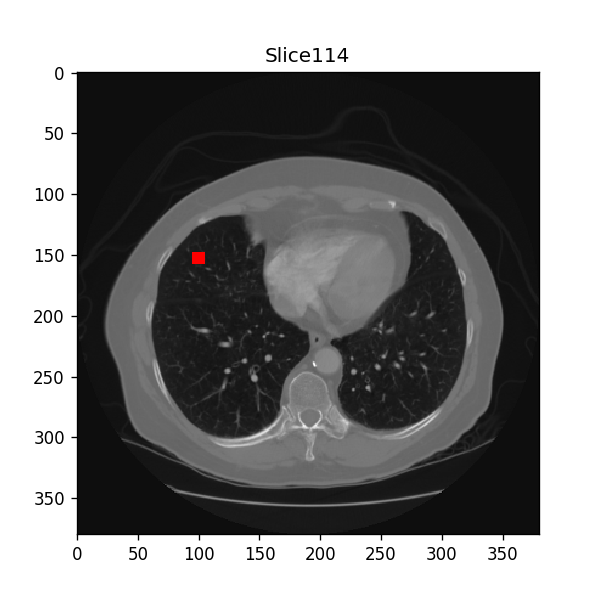

In [43]:
if True:
    
    image3d=scan_1.image_resampled
 
    fig = plt.figure(figsize=(5,5)) # make figure
    ax = plt.subplot(1,1,1)
    im = plt.imshow(image3d[0],'gray')
    
    ztot=5
    rects=[patches.Rectangle((100,100),1,1,linewidth=3,edgecolor='r',facecolor='none') for i in range(ztot)]




    for r in rects:
        ax.add_patch(r)



    # function to update figure
    def updatefig(j):
        # set the data in the axesimage object
        im.set_array(image3d[j])

        

        for i in range(ztot):
            if i <len(scan_1.Zbbox[j]):
                rects[i].set_xy(scan_1.Zbbox[j][i][0:2])
                rects[i].set_height(scan_1.Zbbox[j][i][2])
                rects[i].set_width(scan_1.Zbbox[j][i][3])
            else:
                rects[i].set_xy([512,512])
                

        ax.set_title("Slice"+str(j))
        return im,rects

    # kick off the animation
    ani = animation.FuncAnimation(fig, updatefig, frames=range(len(image3d)),
                                  interval=100, blit=True)
    #ani.save('Chest_Cavity.gif', writer='imagemagick')

    plt.show()

In [41]:
#for i,ann in enumerate(scan_1.anns):
#    print(i,ann.contour_slice_indices)

In [40]:
#scan_1.anns[13].visualize_in_scan()

In [38]:
ind =[k for k,v in scan_1.c2vsz.items() if v!=[]];ind[0:5]

[107, 108, 109, 110, 111]

<IPython.core.display.Javascript object>


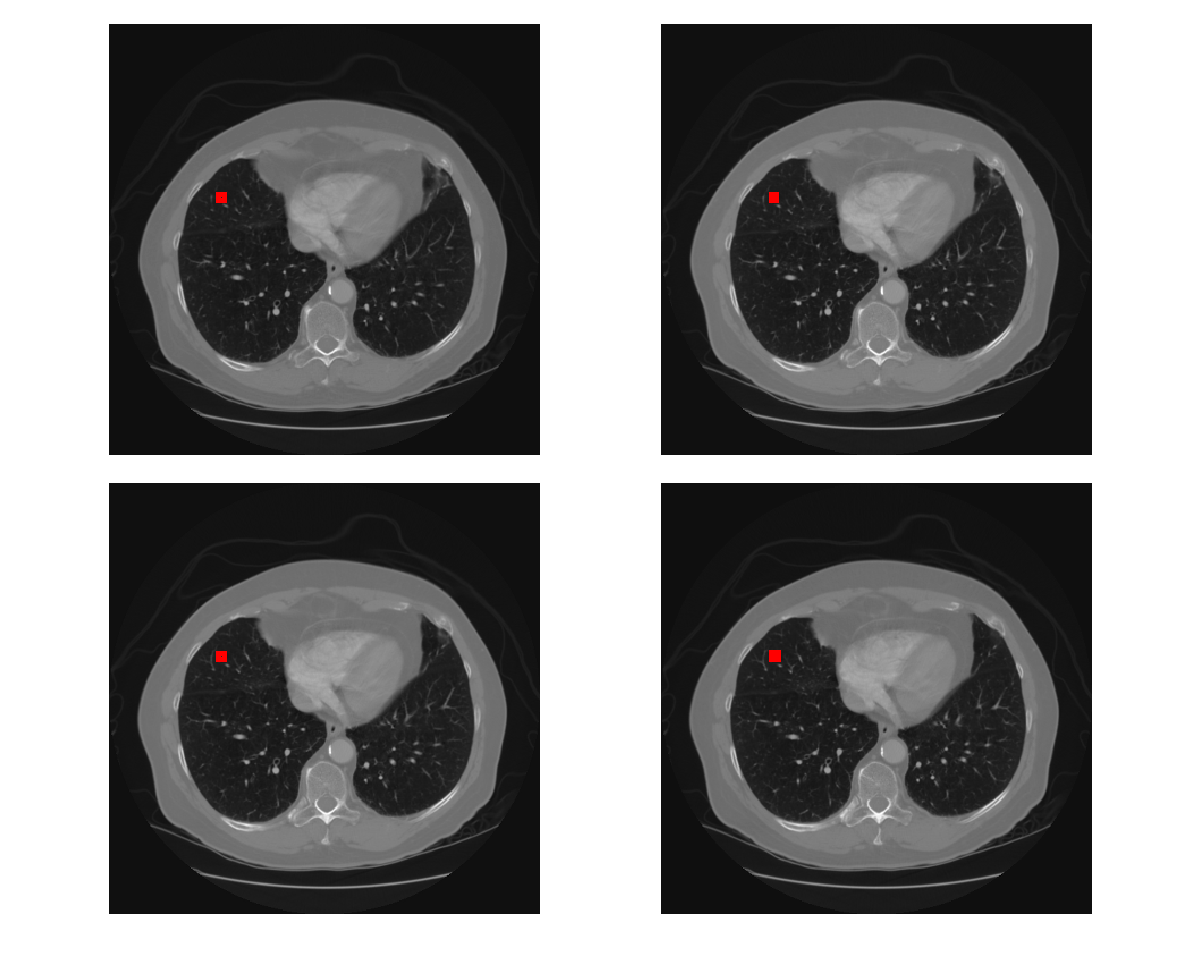

In [39]:
num_rows=2
num_cols=2
zs=4
ztot=5 # number of centroid to possible to view at a slice
f, plots = plt.subplots(num_rows, num_cols, sharex='col', sharey='row', figsize=(10, 8))

rects=[]
for i in range(zs):
    rects.append([patches.Rectangle((100,100),1,1,linewidth=3,edgecolor='r',facecolor='none') for i in range(ztot)])

rects2=[]
for i in range(zs):
    rects2.append([patches.Rectangle((512,512),1,1,linewidth=3,edgecolor='g',facecolor='g') for i in range(ztot)])


for i in range(zs):
    ii=ind[i]
    plots[i // num_cols, i % num_cols].axis('off')
    plots[i // num_cols, i % num_cols].imshow(scan_1.image_resampled[ii],'gray')
    for r in rects[i]:
        plots[i // num_cols, i % num_cols].add_patch(r)

    for j in range(ztot):
        if j <len(scan_1.Zbbox[ii]):
            rects[i][j].set_xy(scan_1.Zbbox[ii][j][0:2])
            rects[i][j].set_height(scan_1.Zbbox[ii][j][2])
            rects[i][j].set_width(scan_1.Zbbox[ii][j][3])
        else:
            rects[i][j].set_xy([512,512])
    for j in range(ztot):
        if j <len(scan_1.Zbbox[ii]):
            rects2[i][j].set_xy(scan_1.Zbbox[ii][j][0:2])
        else:
            rects2[i][j].set_xy([512,512])
plt.tight_layout()
